### STEP **THREE** OF DATA PROCESSING PIPELINE

#### This script imports all Conditional CRF's for each subject and the results are visualized in this script when all CRF's are averaged for both original CRF's and no SuperSaturation CRF's. 
#### This script is mainly to present plots before and after some participants are excluded. Mainly plots for presenation.

#### 2 Types of plots (4 in total): 
####  Average CRF before and after removing some participants for original anf No S.Sat data for all conditions.
#### Avg CRFs with everyones invididual data plotted as the background. For OG data and No S.Sat data. 
#### Data to be exported : exclude participant array, OG Data, No SSat Data

In [275]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [276]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
# dk_labs = ['attnL F1','attnL F2','attnR F1','attnR F2',]
# contrast_levels=np.array([1, 3, 5, 16, 40, 100])
# contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

In [277]:
def GrandCRF(data):
    """This function computes the average by stacking [12x2]
    arrays along 0th dim and then average across the 0th dimension"""
    TotSubs = list(data.values())
    temp = np.stack(TotSubs, axis = 0) # [Subj x 12r x 2c]
    dOut = np.mean(temp, axis = 0)
    return dOut
##########################################################################
def OmitData(SubNames, noisySub_arr):
    """"This function finds and removes a participants data for all files
    returns a np.array with the positions to omit from the grand average
    of CRF
    SubNames = list of subject names
    noisySub_arr = array that must be smaller than the size of SubNames"""
    nS_array = np.array(noisySub_arr)
    omit = np.where(SubNames == nS_array[:,None])[1]
    return omit
######################################################################
def Concat_Dict_Data(NumSubs,SubNames,d1,d2,iters,s2):
    """
    Combine Single and Double Session Participants data
    Returns: Dict and subject name array

    NumSubs: Number of Participants who completed 2x Sessions 
    d1: Dict Data of Participants who completed 2x Sessions for this condition
    d2: Dict Data of Participants who completed 1 Session for this condition
    iters: **Total Subjects** 
    s2: List of subnames for single sessions  
    """
    s1 = SubNames
    add_onInd = int(iters - NumSubs) # single subjs
    CondSubList = np.hstack((s1,s2)) # Combine subject lists 
    d_sess = np.arange(NumSubs) 
    s_sess = np.arange(add_onInd)
    new_list = np.concatenate((d_sess,s_sess+len(d1)))

    condDict = {}
    for Sub in range(int(iters)): # all data for condition
        ind = int(new_list[Sub]) # restart dict inds
        if Sub < len(d1):
            condDict[Sub]  = d1[ind]
        else: # start saving singles session data 
            condDict[Sub]  = d2[ind - len(d1)]
    return condDict , CondSubList 
############################################################################
def FixSaturation(x,NumBins,NumSubs,start,end,col):
    """
    Fix SuperSaturation towards the higher contrasts 
    by setting those lower values to the max response before
    this dip occurs 
    """
    r1 = start
    r2 = end
    cond = col 
    d = np.zeros((NumSubs,NumBins))
    pos_rec = []
    for i in range(NumSubs):
        dataIn = x[i][r1:r2,cond] 
        dataOut = np.zeros((1,NumBins))
        maxpos = np.argmax(dataIn, axis = 0)
        pos_rec.append(maxpos)
        maxamp = dataIn[maxpos]
        if maxpos < NumBins:
            dataOut[0,:maxpos] =  dataIn[:maxpos]
            dataOut[0,maxpos:] = maxamp
            d[i,:] = dataOut
        else:
            d[i,:]  = dataIn
    return d, pos_rec

In [278]:
cp1 = sns.color_palette("husl", 8) # color pallete 1 
cp2 = sns.color_palette("hls", 8)  # color pallete 2

In [279]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[2] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllSess_20240213_1141.pkl', 'AllCondCRF_AllSess_pnlApp_20240229_1633.mat', 'AllCondCRF_AllSess_pnlApp_20240229_1633.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_pnlApp_20240229_1633.pkl
Does File #1 Exist? True


In [280]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'DataSingleSess', 'DSSAttnl', 'DSSAttnR', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [281]:
# data for 2 sess subs
data = loadData['Data']
NumSubs = int(len(data[0].keys()))
SubNames = np.array(loadData['SubNames'])
# data for 1 sess subs
data_1s = loadData['DataSingleSess']
attnL_subs = loadData['DSSAttnl']
attnR_subs = loadData['DSSAttnR']

data_labels = loadData['DictMainKeys'] # condition labels for data + data_1s dict keys
contrast_levels = loadData['ContLevs'] # array for contrast labels (indexing)
contrast_labs = loadData['crfLabs'] # list for contrast labels (plotting)

note = loadData['VoiceMemo'] # personal note
print(note)

['This file contains all subjects [single and double] sessions, avg of CRF [12x2] array, original crfs']


#### Concatenate Double and Single Session Data Based on Respective Session Completed

In [282]:
NumSess = np.zeros((NumConds))
for co in range(NumConds):
    NumSess[co] = int(len(data[co].keys())) + int(len(data_1s[co].keys()))
print(NumSess)

[26. 26. 29. 29.]


In [283]:
CndDict = {}
SubList = {} 

CndDict[0], SubList[0] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[0],d2 = data_1s[0],iters = NumSess[0],s2 = attnL_subs)
CndDict[1], SubList[1] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[1],d2 = data_1s[1],iters = NumSess[1],s2 = attnL_subs)
CndDict[2], SubList[2] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[2],d2 = data_1s[2],iters = NumSess[2],s2 = attnR_subs)
CndDict[3], SubList[3] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[3],d2 = data_1s[3],iters = NumSess[3],s2 = attnR_subs)

In [ ]:
#for co in range(NumConds):
    #print(CndDict[co].keys())
    #print(SubList[co].shape)

In [284]:
sns.set_theme()

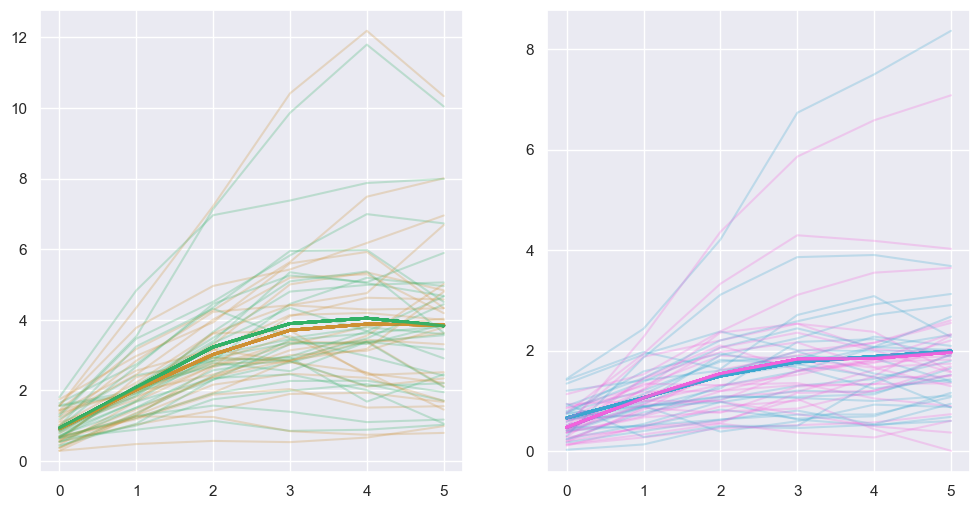

In [428]:
cond = 0

g_crf = GrandCRF(CndDict[cond]) # grand avg for this condition - all subjects 
#print(g_crf.shape)
sub_ind = np.array(SubList[cond]) # subject list array
#print(sub_ind)

fig,axs = plt.subplots(1,2,figsize = (12,6))
for i in range(int(NumSess[cond])):
    dIn = CndDict[cond][i]
    axs[0].plot(dIn[:6,0], color = cp1[1],alpha = 0.25) # pre
    axs[0].plot(g_crf[:6,0], color =  cp1[1],alpha = 0.9, linewidth = 2) # avg pre

    axs[0].plot(dIn[:6,1], color =  cp1[3],alpha = 0.25) # pre 
    axs[0].plot(g_crf[:6,1], color = cp1[3],alpha = 0.9, linewidth = 2)# avg pre

    axs[1].plot(dIn[6:,0], color = cp1[5],alpha = 0.25)# pre
    axs[1].plot(g_crf[6:,0], color = cp1[5],alpha = 0.9, linewidth = 2)# avg pre

    axs[1].plot(dIn[6:,1], color = cp1[7],alpha = 0.25) # pre 
    axs[1].plot(g_crf[6:,1], color = cp1[7],alpha = 0.9, linewidth = 2) # avg pre

[0.66302603 1.06451053 1.49588121 1.77665605 1.88403167 1.99097836][0.37048713 0.5533169  0.84424977 1.2759955  1.40586166 1.48374707]

[1.21875673 1.89448589 2.76225586 3.6906493  3.99282417 4.21659897]


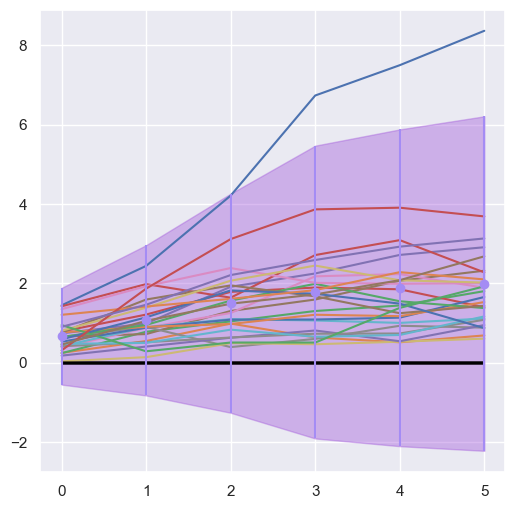

In [451]:
#fig,axs = plt.subplots(figsize = (6,6))
std_Threshold = 1.5 # set std threshold for contrast response function data per bin

SubSetData = np.zeros(((int(NumSess[cond]),NumBins)))

for row in range(int(NumSess[cond])):
    SubSetData[row,:] = CndDict[cond][row][6:,0]
    
AvgPerContrast = np.mean(SubSetData, axis = 0) # find mean 
StdPerContrast = np.std(SubSetData, axis = 0) # find std

StdContrastThreshold = AvgPerContrast + std_Threshold*StdPerContrast # set thresh to 2 std
print(f'{AvgPerContrast}{StdPerContrast}')
print()
print(StdContrastThreshold)

fig,axs = plt.subplots(figsize = (6,6))
for row in range(int(NumSess[cond])):
    plt.plot(SubSetData[row,:])
    plt.hlines(0, xmin = 0, xmax = 5, color = 'black')


plt.errorbar(np.arange(NumBins),AvgPerContrast,yerr = StdContrastThreshold,fmt='o', color = cp1[6])
#plt.fill_between(np.arange(NumBins),-StdPerContrast , StdPerContrast, color='skyblue', alpha=0.4)
plt.fill_between(np.arange(NumBins), AvgPerContrast - StdContrastThreshold, AvgPerContrast + StdContrastThreshold, color=cp2[6], alpha=0.4)
#plt.scatter(np.arange(NumBins),AvgPerContrast, color = 'black')

In [344]:
Sub_OverThreshCounts = np.zeros((int(NumSess[cond]),1)) # counter for how many times subs data was 2std from performance


(26, 1)


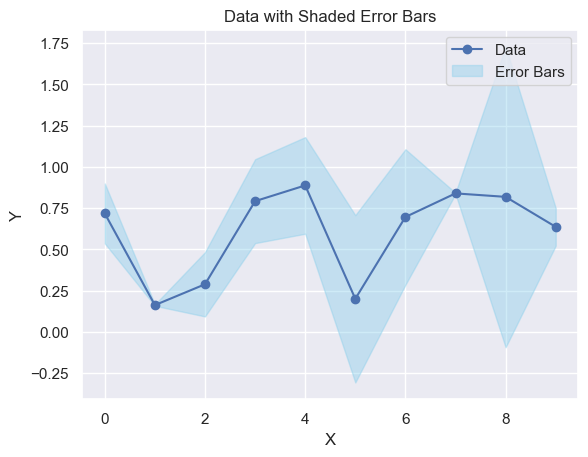

In [384]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.arange(10)
y = np.random.rand(10)
errors = np.random.rand(10)

# Calculate upper and lower bounds for error bars
upper_bound = y + errors
lower_bound = y - errors

# Create the plot
plt.plot(x, y, 'o-', label='Data')
plt.fill_between(x, lower_bound, upper_bound, color='skyblue', alpha=0.4, label='Error Bars')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with Shaded Error Bars')
plt.legend()
plt.show()



Condition: 0, Bin: 4


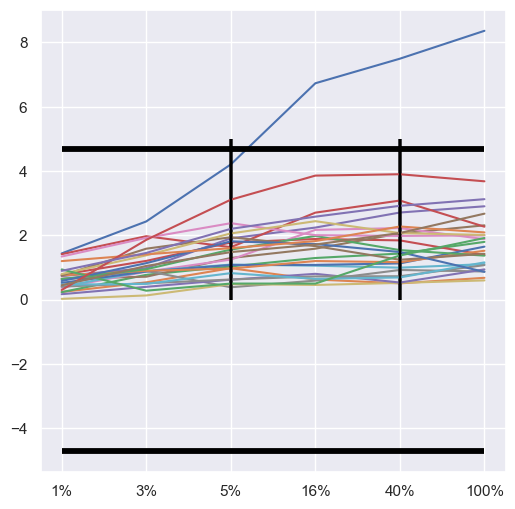

In [322]:
BinInd = 3 # contrast % 
fig,axs = plt.subplots(figsize = (6,6))
print(f'Condition: {cond}, Bin: {BinInd+1}') # condtion (dict key)  

SubSetData = np.zeros(((int(NumSess[cond]),NumBins)))

for row in range(int(NumSess[cond])):
    SubSetData[row,:] = CndDict[cond][row][6:,0]
    plt.plot(SubSetData[row,:])
    plt.vlines(BinInd-1, ymin = 0, ymax = 5, color = 'black')
    plt.vlines(BinInd+1, ymin = 0, ymax = 5, color = 'black')
    plt.hlines(Hi_thresh, xmin = 0, xmax = 5, color = 'black', linewidth = 3)
    plt.hlines(Lo_thresh, xmin = 0, xmax = 5, color = 'black', linewidth = 3)
    plt.xticks(ticks = np.arange(NumBins),labels = contrast_labs)
#for row in range(int(NumSess[cond])):
#    plt.plot(SubSetData[row,:])

In [323]:
Data_Vals = SubSetData[:,BinInd] # array of paticpants average contrast response function for that bin

avg = np.mean(Data_Vals) # average resoponse in mV
std = np.std(Data_Vals) # standard deviation 
Hi_thresh = avg + 2 * std # threshold - max extreme value acceptable 
Lo_thresh = -(avg + 2 * std) # threshold - max extreme value acceptable 

#HiThreshSubs = np.where(Lo_thresh < Data_Vals> Hi_thresh)[0] # find pos of those extreme values
HiThreshSubs = np.where((Lo_thresh > Data_Vals) | (Data_Vals > Hi_thresh))[0]
print(HiThreshSubs)

# print(f'Mean: {avg}, Std: {std}, thresh: {Hi_thresh,Lo_thresh}')
# print(f'Position of sub with data that exceeds 2 stds: {HiThreshSubs}, vals: {Data_Vals[HiThreshSubs]}')

# KeepSub = np.ones((int(len(sub_ind)))) # bool to exclude from analysis
# KeepSub[HiThreshSubs] = 0 # index to process subj data
# #print(KeepSub)

# # To see whos data was excluded (participant #)
# NoisySub = sub_ind[HiThreshSubs]
# print(NoisySub)

[0]


In [ ]:
DubiousSubs = []
DubiousSubs.append(NoisySub)
print(DubiousSubs)

In [ ]:
['2651', '345202']

# Incl_Sub_Ind = {}

# Incl_Sub_Ind[0] = []
# Incl_Sub_Ind[1] = []
# Incl_Sub_Ind[2] = []
# Incl_Sub_Ind[3] = []

#### Use this if planning on excluding participants / grouping subj responses

In [ ]:
noisySub = ['2651','2652', '2671' ,'2668','2696']
noisySub = np.sort(noisySub)
omit = OmitData(SubNames,noisySub)
omit = np.array(omit)
print(f'Subjects Data to omit: {SubNames[omit]}')
GoodSubjs = np.ones((int(len(SubNames))))
GoodSubjs[omit] = 0 # index to process subj data
print(GoodSubjs)

#### Remove Subjects from Average Contrast Response Function

In [ ]:
cleanData = {}

for co in range(NumConds):
    cleanData[co] = {}
    for sub in range(len(SubNames)):
        xIn = data[co][sub] # 12 x 2
        pos = GoodSubjs[sub]
        if pos == 1:
            #print(f'keep {SubNames[sub]}')
            cleanData[co][sub] = xIn
        #else: 
            #print(f'removing subject {SubNames[sub]}')
print(f'Analysis Reduced to {len(cleanData[0].keys())} subjects, total {len(SubNames)}')

### 2 Options for plotting: Everyones CRF's / Select Subjects CRF's...

In [ ]:
avgCRF_ori = {}
avgCRF_clean = {}
for c in range(4):#(NumConds):
    avgCRF_ori[c]= GrandCRF(data = data[c]) # all participants data
    avgCRF_clean[c]= GrandCRF(data = cleanData[c]) # select participants 
#print(avgCRF[0].shape)

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(2,4, figsize=(14,8), sharey = True)

for col in range(NumConds):
    d_In = avgCRF_ori[col]
    axs[0,col].plot(d_In[:6,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[0,col].plot(d_In[:6,1:],label = f'Post {dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[1,col].plot(d_In[6:,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[1,col].plot(d_In[6:,1],label = f' Post{dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[0,col].set_xlabel('Contrast %')
    axs[0,col].set_ylabel('Amplitude (mV)')
    axs[0,col].legend(loc = 'lower right')

    axs[1,col].set_xlabel('Contrast %')
    axs[1,col].set_ylabel('Amplitude (mV)')
    axs[1,col].legend(loc = 'lower right')

    axs[0,col].legend(loc = 'lower right')
    axs[0,col].set_xticks(range(len(contrast_levels_labs)))
    axs[0,col].set_xticklabels(contrast_levels_labs)
    axs[1,col].set_xticks(range(len(contrast_levels_labs)))
    axs[1,col].set_xticklabels(contrast_levels_labs)

plt.suptitle('Average CRF Across All Participants')
plt.tight_layout()

In [ ]:
sns.set_theme()
fig, axs = plt.subplots(2,4, figsize=(16,9), sharey = True)

for col in range(NumConds):
    d_In = avgCRF_clean[col]
    axs[0,col].plot(d_In[:6,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[0,col].plot(d_In[:6,1:],label = f'Post {dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[1,col].plot(d_In[6:,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[1,col].plot(d_In[6:,1],label = f' Post{dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[0,col].set_xlabel('Contrast %')
    axs[0,col].set_ylabel('Amplitude (mV)')
    axs[0,col].legend(loc = 'lower right')

    axs[1,col].set_xlabel('Contrast %')
    axs[1,col].set_ylabel('Amplitude (mV)')
    axs[1,col].legend(loc = 'lower right')

    axs[0,col].legend(loc = 'lower right')
    axs[0,col].set_xticks(range(len(contrast_levels_labs)))
    axs[0,col].set_xticklabels(contrast_levels_labs)
    axs[1,col].set_xticks(range(len(contrast_levels_labs)))
    axs[1,col].set_xticklabels(contrast_levels_labs)

plt.suptitle('Average CRF Across All Participants - removed subjects')
plt.tight_layout()

In [ ]:
pre = 1
post = 0
ss = 0
sse = 6
counter = 0 

fig,axs = plt.subplots(2,4, figsize = (16,20), sharey = False)
for co in data.keys(): # 4
        dIn = data[co] # each subjects crf
        avg_data = avgCRF_ori[co] # avgeraged crf
        for subiter in dIn.keys(): # all subjects
                xIn = dIn[subiter]
                for t in range(2):
                        if t == 0:
                                lab = 'pre'
                        else:
                                lab = 'post'        
                        axs[0,co].plot(xIn[:sse,t], color =  cp1[t*5], alpha = 0.5, linewidth = 1)
                        axs[1,co].plot(xIn[sse:,t], color =  cp1[t*5], alpha = 0.5, linewidth = 1)
                        axs[0,co].plot(avg_data[:sse,t], color =  cp1[t*5], label = lab, linewidth = 4)
                        axs[1,co].plot(avg_data[sse:,t],color =  cp1[t*5], label = lab, linewidth = 4) # plot pre and post via t 
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
                        axs[0,co].legend(labels = ['Pre','Mean Pre','Post','Mean Post'], loc = 'upper left')
plt.suptitle(f'All Subj CRFs', fontsize = 25)
plt.tight_layout()

In [ ]:
pre = 1
post = 0
ss = 0
sse = 6
counter = 0 

fig,axs = plt.subplots(2,4, figsize = (16,20), sharey = False)
for co in data.keys(): # 4
        dIn = cleanData[co] # each subjects crf
        avg_data = avgCRF_clean[co] # avgeraged crf
        for subiter in dIn.keys(): # all subjects
                xIn = dIn[subiter]
                for t in range(2):
                        if t == 0:
                                lab = 'pre'
                        else:
                                lab = 'post'
                        axs[0,co].plot(xIn[:sse,t], color = cp1[t*3], label = lab, alpha = 0.5, linewidth = 1)
                        axs[0,co].plot(avg_data[:sse,t], color = cp1[t*3], linewidth = 4)
                        axs[1,co].plot(xIn[sse:,t], color = cp1[t*3], label = lab, alpha = 0.5, linewidth = 1)
                        axs[1,co].plot(avg_data[sse:,t],color = cp1[t*3], linewidth = 4) # plot pre and post via t 
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
                        axs[0,co].legend(labels = ['Pre','Mean Pre','Post','Mean Post'], loc = 'upper left')
plt.suptitle(f'Select Subj CRFs', fontsize = 25)
plt.tight_layout()

In [ ]:
### %history use this if you delete ur cell code and its recent ...
### cntrl and / hashtags many lines of code at once 
#### This script imports all Confitional CRF's for each subject and the results are visualized in this script when all CRF's are averaged
##### tip: use esc + z to recover accidentally deleted cell

In [ ]:
# pre = 1
# post = 0
# ss = 0
# sse = 6
# counter = 0 
# labels = []
# fig,axs = plt.subplots(2,4, figsize = (16,8), sharey = True)
# for co in data.keys(): # 4
#         dIn = data[co]
#         for subiter in dIn.keys(): # all subjects
#                 xIn = dIn[subiter]
#                 for t in range(2):
#                         if t == 0:
#                                 lab = 'pre'
#                         else:
#                                 lab = 'post'
#                         labels.append(lab)
#                         axs[0,co].plot(xIn[:sse,t], color = cp1[t*5], label = lab)
#                         axs[1,co].plot(xIn[sse:,t], color = cp1[t*5], label = lab)#
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
#                         axs[0,co].legend(labels = labels[0:2], loc = 'upper left')
# plt.suptitle(f'All Subj CRFs')
# plt.tight_layout()
# ###########################################################################################
# labels = []
# fig,axs = plt.subplots(2,4, figsize = (16,8), sharey = True)
# for co in cleanData.keys(): # 4
#         dIn = cleanData[co]
#         for subiter in dIn.keys(): # all subjects
#                 xIn = dIn[subiter]
#                 for t in range(2):
#                         if t == 0:
#                                 lab = 'pre'
#                         else:
#                                 lab = 'post'
#                         labels.append(lab)
#                         axs[0,co].plot(xIn[:sse,t], color = cp1[t*5], label = lab)
#                         axs[1,co].plot(xIn[sse:,t], color = cp1[t*5], label = lab)#
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
#                         axs[0,co].legend(labels = labels[0:2], loc = 'upper left')
# plt.suptitle(f'Select CRFs')
# plt.tight_layout()